### 0. 라이브러리 호출

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, KMeansSMOTE

### 1. 데이터 불러오기

In [2]:
# 회사별 직무, 규모
job_companies = pd.read_csv('train_job/job_companies.csv')
# 직무별 태그
job_tags = pd.read_csv('train_job/job_tags.csv')
# 태그별 키워드
tags = pd.read_csv('train_job/tags.csv')
# 유저별 태그
user_tags = pd.read_csv('train_job/user_tags.csv')

# 유저별 직무, 지원 여부
train = pd.read_csv('train_job/train.csv')

In [1]:
test_job = pd.read_csv('test_folder/test_job.csv')
sample_output_job = pd.read_csv('test_folder/sample_output_job.csv')

NameError: name 'pd' is not defined

### 2. EDA, Preprocessing

In [6]:
job_companies.head() # 회사ID, 직무ID, 회사규모

,companyID,jobID,companySize
0,00411460f7c92d2124a67ea0f4cb5f85,e5f6ad6ce374177eef023bf5d0c018b6,NaN
1,1905aedab9bf2477edc068a355bba31a,185e65bc40581880c4f2c82958de8cfe,11-50
2,89fcd07f20b6785b92134bd6c1d0fa42,0537fb40a68c18da59a35c2bfe1ca554,101-200
3,acf4b89d3d503d8252c9c4ba75ddbf6d,b7ee6f5f9aa5cd17ca1aea43ce848496,1-10
4,fb7b9ffa5462084c5f4e7e85a093e6d7,efe937780e95574250dabe07151bdc23,NaN


In [7]:
job_companies.info() # 회사 규모 기재되지 않은 90곳 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   companyID    733 non-null    object
 1   jobID        733 non-null    object
 2   companySize  643 non-null    object
dtypes: object(3)
memory usage: 17.3+ KB


In [8]:
job_companies['companyID'].value_counts()

companyID
b5dc4e5d9b495d0196f61d45b26ef33e    18
3b8a614226a953a8cd9526fca6fe9ba5    15
4f6ffe13a5d75b2d6a3923922b3922e5    14
c058f544c737782deacefa532d9add4c    12
eddea82ad2755b24c4e168c5fc2ebd40    12
                                    ..
facf9f743b083008a894eee7baa16469     1
ed4227734ed75d343320b6a5fd16ce57     1
bb7946e7d85c81a9e69fee1cea4a087c     1
7a6a74cbe87bc60030a4bd041dd47b78     1
b5b41fac0361d157d9673ecb926af5ae     1
Name: count, Length: 276, dtype: int64

In [10]:
job_tags.head() # 직무ID, 직무태그ID

,jobID,tagID
0,320722549d1751cf3f247855f937b982,d38901788c533e8286cb6400b40b386d
1,e744f91c29ec99f0e662c9177946c627,3948ead63a9f2944218de038d8934305
2,e744f91c29ec99f0e662c9177946c627,0e095e054ee94774d6a496099eb1cf6a
3,e820a45f1dfc7b95282d10b6087e11c0,7d771e0e8f3633ab54856925ecdefc5d
4,e820a45f1dfc7b95282d10b6087e11c0,6c8dba7d0df1c4a79dd07646be9a26c8


In [11]:
job_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   jobID   3477 non-null   object
 1   tagID   3477 non-null   object
dtypes: object(2)
memory usage: 54.5+ KB


In [12]:
job_tags.groupby('jobID')['tagID'].value_counts() # 직무당 다양한 태그 존재

jobID                             tagID                           
00ac8ed3b4327bdd4ebbebcb2ba10a00  0c048b3a434e49e655c1247efb389cec    1
                                  69d658d0b2859e32cd4dc3b970c8496c    1
                                  884d79963bd8bc0ae9b13a1aa71add73    1
                                  9a3d458322d70046f63dfd8b0153ece4    1
                                  aace49c7d80767cffec0e513ae886df0    1
                                                                     ..
ffeabd223de0d4eacb9a3e6e53e5448d  602d1305678a8d5fdb372271e980da6a    1
                                  a1d50185e7426cbb0acad1e6ca74b9aa    1
                                  a9078e8653368c9c291ae2f8b74012e7    1
ffeed84c7cb1ae7bf4ec4bd78275bb98  3948ead63a9f2944218de038d8934305    1
                                  bd4c9ab730f5513206b999ec0d90d1fb    1
Name: count, Length: 3477, dtype: int64

In [13]:
tags.head() # 직무태그ID, 태그가 의미하는 키워드

,tagID,keyword
0,602d1305678a8d5fdb372271e980da6a,Amazon Web Services(AWS)
1,e3251075554389fe91d17a794861d47b,Tensorflow
2,a1d50185e7426cbb0acad1e6ca74b9aa,Docker
3,884d79963bd8bc0ae9b13a1aa71add73,Git
4,4122cb13c7a474c1976c9706ae36521d,Python


In [14]:
user_tags.head() # 유저ID, 유저가 가진 태그

,userID,tagID
0,e576423831e043f7928d9ac113abbe6f,82c2559140b95ccda9c6ca4a8b981f1e
1,e576423831e043f7928d9ac113abbe6f,2ba8698b79439589fdd2b0f7218d8b07
2,e576423831e043f7928d9ac113abbe6f,351b33587c5fdd93bd42ef7ac9995a28
3,e576423831e043f7928d9ac113abbe6f,81e5f81db77c596492e6f1a5a792ed53
4,e576423831e043f7928d9ac113abbe6f,0e095e054ee94774d6a496099eb1cf6a


In [15]:
user_tags.drop_duplicates(subset=['userID','tagID'], inplace=True) # 유저당 직무 태그 중복 존재하므로 제거 필요

In [16]:
user_tags['userID'].value_counts() # 최소 1개부터 최대 50개의 기술 스택 가진 유저도 있음

userID
ac9e4248f16d319a00b803477db2433a    50
f69054686ba46877b6397ccdb8f51762    34
788ecdd13f033f8131eecd90ee59993e    34
eeedf6d4d717eba333e1b53f1b5375c8    33
b052e2e0c0ad1b2d5036bd56e27d061c    33
                                    ..
68a61f9415f07a4040f7afe82a058608     1
847a7251b574c85da9c2248125c2df93     1
4802630177809fcf861411501a443abb     1
b292c42b08d209a8baa530adc393671d     1
37b96469b46dfd9919cd984b788ceb17     1
Name: count, Length: 196, dtype: int64

In [17]:
train.head() # 유저가 해당 직무에 지원했는지 안했는지

,userID,jobID,applied
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,0
1,6377fa90618fae77571e8dc90d98d409,55b37c5c270e5d84c793e486d798c01d,0
2,8ec0888a5b04139be0dfe942c7eb4199,0fcbc61acd0479dc77e3cccc0f5ffca7,1
3,f862b39f767d3a1991bdeb2ea1401c9c,3b5dca501ee1e6d8cd7b905f4e1bf723,0
4,cac14930c65d72c16efac2c51a6b7f71,287e03db1d99e0ec2edb90d079e142f3,0


In [18]:
job_companies[~job_companies['companySize'].isna()]

,companyID,jobID,companySize
1,1905aedab9bf2477edc068a355bba31a,185e65bc40581880c4f2c82958de8cfe,11-50
2,89fcd07f20b6785b92134bd6c1d0fa42,0537fb40a68c18da59a35c2bfe1ca554,101-200
3,acf4b89d3d503d8252c9c4ba75ddbf6d,b7ee6f5f9aa5cd17ca1aea43ce848496,1-10
5,ac627ab1ccbdb62ec96e702f07f6425b,a1140a3d0df1c81e24ae954d935e8926,51-100
6,9ad6aaed513b73148b7d49f70afcfb32,eb86d510361fc23b59f18c1bc9802cc6,11-50
...,...,...,...
725,f0adc8838f4bdedde4ec2cfad0515589,7501e5d4da87ac39d782741cd794002d,11-50
727,4496bf24afe7fab6f046bf4923da8de6,b51a15f382ac914391a58850ab343b00,11-50
728,b5dc4e5d9b495d0196f61d45b26ef33e,fa3a3c407f82377f55c19c5d403335c7,51-100
729,2dace78f80bc92e6d7493423d729448e,d7a728a67d909e714c0774e22cb806f2,51-100


In [19]:
job_companies['companySize'].value_counts()

companySize
11-50       260
51-100      142
1-10        100
101-200      60
201-500      56
1000 이상      13
501-1000     12
Name: count, dtype: int64

In [20]:
def change_size(x):

    if x == "1000 이상":

        return 1000
    
    else:

        y = (int(x.split("-")[0]) + int(x.split("-")[1]))//2 # string 평균 값으로 대치

        return y

job_companies['companySize'] = job_companies['companySize'].apply(lambda x:change_size(x) if type(x) == str else x)

In [21]:
job_companies['companySize'].value_counts()

companySize
30.0      260
75.0      142
5.0       100
150.0      60
350.0      56
1000.0     13
750.0      12
Name: count, dtype: int64

In [22]:
job_companies # 직무가 많을 수록 회사 규모도 크지 않을까...

,companyID,jobID,companySize
0,00411460f7c92d2124a67ea0f4cb5f85,e5f6ad6ce374177eef023bf5d0c018b6,NaN
1,1905aedab9bf2477edc068a355bba31a,185e65bc40581880c4f2c82958de8cfe,30.0
2,89fcd07f20b6785b92134bd6c1d0fa42,0537fb40a68c18da59a35c2bfe1ca554,150.0
3,acf4b89d3d503d8252c9c4ba75ddbf6d,b7ee6f5f9aa5cd17ca1aea43ce848496,5.0
4,fb7b9ffa5462084c5f4e7e85a093e6d7,efe937780e95574250dabe07151bdc23,NaN
...,...,...,...
728,b5dc4e5d9b495d0196f61d45b26ef33e,fa3a3c407f82377f55c19c5d403335c7,75.0
729,2dace78f80bc92e6d7493423d729448e,d7a728a67d909e714c0774e22cb806f2,75.0
730,443cb001c138b2561a0d90720d6ce111,d81f9c1be2e08964bf9f24b15f0e4900,NaN
731,b5b41fac0361d157d9673ecb926af5ae,ae0eb3eed39d2bcef4622b2499a05fe6,NaN


In [23]:
company_jobs = job_companies['companyID'].value_counts().reset_index()

company_jobs.head()

,companyID,count
0,b5dc4e5d9b495d0196f61d45b26ef33e,18
1,3b8a614226a953a8cd9526fca6fe9ba5,15
2,4f6ffe13a5d75b2d6a3923922b3922e5,14
3,c058f544c737782deacefa532d9add4c,12
4,eddea82ad2755b24c4e168c5fc2ebd40,12


In [24]:
company_size = job_companies[['companyID','companySize']].drop_duplicates('companyID')

company_size.head()

,companyID,companySize
0,00411460f7c92d2124a67ea0f4cb5f85,NaN
1,1905aedab9bf2477edc068a355bba31a,30.0
2,89fcd07f20b6785b92134bd6c1d0fa42,150.0
3,acf4b89d3d503d8252c9c4ba75ddbf6d,5.0
4,fb7b9ffa5462084c5f4e7e85a093e6d7,NaN


In [25]:
company_jobs_size = pd.merge(company_jobs, company_size, how='inner', left_on='companyID', right_on='companyID')

company_jobs_size.head()

,companyID,count,companySize
0,b5dc4e5d9b495d0196f61d45b26ef33e,18,75.0
1,3b8a614226a953a8cd9526fca6fe9ba5,15,350.0
2,4f6ffe13a5d75b2d6a3923922b3922e5,14,30.0
3,c058f544c737782deacefa532d9add4c,12,150.0
4,eddea82ad2755b24c4e168c5fc2ebd40,12,30.0


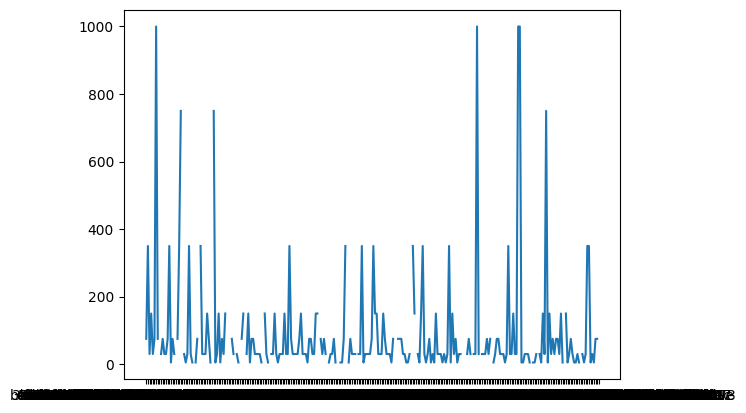

In [26]:
plt.figure()
plt.plot(company_jobs_size['companyID'], company_jobs_size['companySize'])
plt.show()

In [27]:
avg_of_size = int(job_companies['companySize'].mean())

job_companies['companySize'].fillna(avg_of_size, inplace=True)

In [28]:
job_tagkeyword = pd.merge(job_tags, tags, how = 'inner', left_on = 'tagID', right_on = 'tagID')
job_tagkeyword.sort_values(by=['jobID','keyword'], inplace=True)
job_tagkeyword.head()

,jobID,tagID,keyword
1293,00ac8ed3b4327bdd4ebbebcb2ba10a00,aace49c7d80767cffec0e513ae886df0,Android
1295,00ac8ed3b4327bdd4ebbebcb2ba10a00,0c048b3a434e49e655c1247efb389cec,Firebase
1292,00ac8ed3b4327bdd4ebbebcb2ba10a00,884d79963bd8bc0ae9b13a1aa71add73,Git
1294,00ac8ed3b4327bdd4ebbebcb2ba10a00,f47330643ae134ca204bf6b2481fec47,Java
3032,00ac8ed3b4327bdd4ebbebcb2ba10a00,9a3d458322d70046f63dfd8b0153ece4,Kotlin


In [29]:
job_keywords = pd.get_dummies(job_tagkeyword, columns=['keyword']).drop(columns='tagID').groupby('jobID').sum().reset_index()

job_keywords.head()

,jobID,keyword_.NET,keyword_ASP,keyword_ASP.NET,keyword_AWS Backup,keyword_AWS CloudWatch,keyword_AWS DynamoDB,keyword_AWS EC2,keyword_AWS ECS,keyword_AWS EKS,...,keyword_XML,keyword_gRPC,keyword_gensim,keyword_gulp,keyword_i18n,keyword_iOS,keyword_jQuery,keyword_mSQL,keyword_styled-components,keyword_web3.js
0,00ac8ed3b4327bdd4ebbebcb2ba10a00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00e26af6ac3b1c1c49d7c3d79c60d000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,00ec53c4682d36f5c4359f4ae7bd7ba1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,013a006f03dbc5392effeb8f18fda755,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0188e8b8b014829e2fa0f430f0a95961,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
job_tagkeword_concat = job_tagkeyword.groupby('jobID').apply(lambda x: ', '.join(x.keyword)).reset_index().rename(columns={0:'keywords'})

job_tagkeword_concat.head()

,jobID,keywords
0,00ac8ed3b4327bdd4ebbebcb2ba10a00,"Android, Firebase, Git, Java, Kotlin, REST API..."
1,00e26af6ac3b1c1c49d7c3d79c60d000,"Android, Angular, AngularJS, C++, Java, Kotlin..."
2,00ec53c4682d36f5c4359f4ae7bd7ba1,"ES6, GraphQL, ReactJS, Redux.js"
3,013a006f03dbc5392effeb8f18fda755,"C, C#, MSSQL(Microsoft SQL Server)"
4,0188e8b8b014829e2fa0f430f0a95961,"Java, Python, Spring"


In [31]:
train_data, test_data = train_test_split(train, train_size=0.7, stratify=train['applied'])

1. (유저가 지원한 직무들의 태그들 - 지원 직무의 태그들) 유사도 tag_similarity 계산
2. (유저가 지원한 회사 규모들 - 지원 직무(회사)의 규모) 변수 활용

In [32]:
train_data1 = pd.merge(train_data, job_companies, how='inner', left_on = 'jobID', right_on = 'jobID').drop(columns='companyID')[['userID','jobID','companySize','applied']]

train_data1.head()

,userID,jobID,companySize,applied
0,6eb6e75fddec0218351dc5c0c8464104,1651cf0d2f737d7adeab84d339dbabd3,75.0,0
1,68a61f9415f07a4040f7afe82a058608,aa942ab2bfa6ebda4840e7360ce6e7ef,30.0,0
2,2eeb9064f7f5b2569912cbb772a96438,d93ed5b6db83be78efb0d05ae420158e,75.0,0
3,b052e2e0c0ad1b2d5036bd56e27d061c,c51ce410c124a10e0db5e4b97fc2af39,108.0,0
4,b3c865b84617fa5e555865ebe0e54612,2afe4567e1bf64d32a5527244d104cea,150.0,0


In [33]:
test_data1 = pd.merge(test_data, job_companies, how='inner', left_on = 'jobID', right_on = 'jobID').drop(columns='companyID')[['userID','jobID','companySize','applied']]

test_data1.head()

,userID,jobID,companySize,applied
0,8ec0888a5b04139be0dfe942c7eb4199,288cc0ff022877bd3df94bc9360b9c5d,30.0,0
1,8ec72a61b2adad097a1c3aa06751e8c4,2df45244f09369e16ea3f9117ca45157,108.0,0
2,cb08b2c94dbb772324444bb4ed7cc1a4,9b70e8fe62e40c570a322f1b0b659098,150.0,1
3,3203e06c1efc6fdb23016650d1d1888c,437d7d1d97917cd627a34a6a0fb41136,350.0,0
4,3532ee676d13916210e903ff4d85c04f,3dc4876f3f08201c7c76cb71fa1da439,30.0,0


In [34]:
user_size = train_data1.groupby('userID')['companySize'].mean().reset_index().rename(columns={'companySize':'avg_of_size'})

user_size.head()

,userID,avg_of_size
0,0004289ee1c7b8b08c77e19878106ae3,84.173913
1,00dd1479a58930a357e7b4e2ab4c9f33,202.187500
2,015b469419f616144c13e0194f880af7,30.000000
3,01ed443356f762e9132b58f8c80e131d,230.142857
4,03c60b7fc8519077914166ebcfbd6a34,129.833333


In [35]:
test_user_size = test_data1.groupby('userID')['companySize'].mean().reset_index().rename(columns={'companySize':'avg_of_size'})

test_user_size.head()

,userID,avg_of_size
0,0004289ee1c7b8b08c77e19878106ae3,44.666667
1,00dd1479a58930a357e7b4e2ab4c9f33,21.666667
2,015b469419f616144c13e0194f880af7,30.000000
3,01ed443356f762e9132b58f8c80e131d,129.000000
4,03c60b7fc8519077914166ebcfbd6a34,168.500000


In [36]:
train_data2 = pd.merge(train_data1, user_size, how='inner', left_on = 'userID', right_on = 'userID')[['userID','avg_of_size','jobID','companySize','applied']]

train_data2.head()

,userID,avg_of_size,jobID,companySize,applied
0,6eb6e75fddec0218351dc5c0c8464104,159.222222,1651cf0d2f737d7adeab84d339dbabd3,75.0,0
1,68a61f9415f07a4040f7afe82a058608,82.560000,aa942ab2bfa6ebda4840e7360ce6e7ef,30.0,0
2,2eeb9064f7f5b2569912cbb772a96438,79.370370,d93ed5b6db83be78efb0d05ae420158e,75.0,0
3,b052e2e0c0ad1b2d5036bd56e27d061c,92.782609,c51ce410c124a10e0db5e4b97fc2af39,108.0,0
4,b3c865b84617fa5e555865ebe0e54612,111.215686,2afe4567e1bf64d32a5527244d104cea,150.0,0


In [37]:
test_data2 = pd.merge(test_data1, test_user_size, how='inner', left_on = 'userID', right_on = 'userID')[['userID','avg_of_size','jobID','companySize','applied']]

test_data2.head()

,userID,avg_of_size,jobID,companySize,applied
0,8ec0888a5b04139be0dfe942c7eb4199,56.000000,288cc0ff022877bd3df94bc9360b9c5d,30.0,0
1,8ec72a61b2adad097a1c3aa06751e8c4,69.600000,2df45244f09369e16ea3f9117ca45157,108.0,0
2,cb08b2c94dbb772324444bb4ed7cc1a4,85.375000,9b70e8fe62e40c570a322f1b0b659098,150.0,1
3,3203e06c1efc6fdb23016650d1d1888c,84.826087,437d7d1d97917cd627a34a6a0fb41136,350.0,0
4,3532ee676d13916210e903ff4d85c04f,26.071429,3dc4876f3f08201c7c76cb71fa1da439,30.0,0


In [38]:
train_data3 = pd.merge(train_data2, job_tagkeword_concat, how='inner', left_on = 'jobID', right_on = 'jobID').rename(columns={'keywords':'job_keywords'})[['userID','avg_of_size','jobID','companySize','job_keywords','applied']]

train_data3.head()

,userID,avg_of_size,jobID,companySize,job_keywords,applied
0,6eb6e75fddec0218351dc5c0c8464104,159.222222,1651cf0d2f737d7adeab84d339dbabd3,75.0,"AngularJS, CSS, HTML, JavaScript, Node.js, Rea...",0
1,68a61f9415f07a4040f7afe82a058608,82.560000,aa942ab2bfa6ebda4840e7360ce6e7ef,30.0,"CSS, Django, HTML, Java, JavaScript, MongoDB, ...",0
2,2eeb9064f7f5b2569912cbb772a96438,79.370370,d93ed5b6db83be78efb0d05ae420158e,75.0,"Docker, Go, Linux, NoSQL, Node.js, Python, Rub...",0
3,b052e2e0c0ad1b2d5036bd56e27d061c,92.782609,c51ce410c124a10e0db5e4b97fc2af39,108.0,"Amazon Web Services(AWS), Docker, Kubernetes, ...",0
4,b3c865b84617fa5e555865ebe0e54612,111.215686,2afe4567e1bf64d32a5527244d104cea,150.0,"Android, C, C++, Deep Learning, iOS",0


In [39]:
test_data3 = pd.merge(test_data2, job_tagkeword_concat, how='inner', left_on = 'jobID', right_on = 'jobID').rename(columns={'keywords':'job_keywords'})[['userID','avg_of_size','jobID','companySize','job_keywords','applied']]

test_data3.head()

,userID,avg_of_size,jobID,companySize,job_keywords,applied
0,8ec0888a5b04139be0dfe942c7eb4199,56.000000,288cc0ff022877bd3df94bc9360b9c5d,30.0,"AWS EC2, CSS, GitHub, HTML5, Ruby on Rails",0
1,8ec72a61b2adad097a1c3aa06751e8c4,69.600000,2df45244f09369e16ea3f9117ca45157,108.0,"Django, Python",0
2,cb08b2c94dbb772324444bb4ed7cc1a4,85.375000,9b70e8fe62e40c570a322f1b0b659098,150.0,"Elasticsearch, GCP(Google Cloud Platform), JPA...",1
3,3203e06c1efc6fdb23016650d1d1888c,84.826087,437d7d1d97917cd627a34a6a0fb41136,350.0,".NET, C#, HTML, JavaScript, MSSQL(Microsoft SQ...",0
4,3532ee676d13916210e903ff4d85c04f,26.071429,3dc4876f3f08201c7c76cb71fa1da439,30.0,"Machine Learning, Python",0


In [40]:
user_tagkeyword_concat = train_data3.groupby('userID').apply(lambda x: ', '.join(x.job_keywords)).reset_index().rename(columns={0:'user_keywords'})

user_tagkeyword_concat.head()

,userID,user_keywords
0,0004289ee1c7b8b08c77e19878106ae3,"AWS Backup, Apache, Django, ExpressJS, Nginx, ..."
1,00dd1479a58930a357e7b4e2ab4c9f33,"AWS EC2, AWS RDS, Apache Kafka, CI/CD, Docker,..."
2,015b469419f616144c13e0194f880af7,"Celery, Flask, Git, MariaDB, MySQL, NCP(Naver ..."
3,01ed443356f762e9132b58f8c80e131d,"Java, Linux, MySQL, Git, JIRA, Java, Oracle, C..."
4,03c60b7fc8519077914166ebcfbd6a34,"Java, NoSQL, OOP, Spring, Database, Ruby on Ra..."


In [41]:
test_user_tagkeyword_concat = test_data3.groupby('userID').apply(lambda x: ', '.join(x.job_keywords)).reset_index().rename(columns={0:'user_keywords'})

test_user_tagkeyword_concat.head()

,userID,user_keywords
0,0004289ee1c7b8b08c77e19878106ae3,"Django, ExpressJS, GCP(Google Cloud Platform),..."
1,00dd1479a58930a357e7b4e2ab4c9f33,"Django, Git, Python, ES6, Git, JavaScript, Nex..."
2,015b469419f616144c13e0194f880af7,"Flask, Git, MariaDB, MySQL, Naver Cloud Platfo..."
3,01ed443356f762e9132b58f8c80e131d,"Elasticsearch, GCP(Google Cloud Platform), JPA..."
4,03c60b7fc8519077914166ebcfbd6a34,"Java, MySQL, Spring, Java, Java, Linux, MySQL,..."


In [42]:
train_data4 = pd.merge(train_data3, user_tagkeyword_concat, how='inner', left_on = 'userID', right_on = 'userID')[['userID','avg_of_size','user_keywords','jobID','companySize','job_keywords','applied']]

train_data4.head()

,userID,avg_of_size,user_keywords,jobID,companySize,job_keywords,applied
0,6eb6e75fddec0218351dc5c0c8464104,159.222222,"AngularJS, CSS, HTML, JavaScript, Node.js, Rea...",1651cf0d2f737d7adeab84d339dbabd3,75.0,"AngularJS, CSS, HTML, JavaScript, Node.js, Rea...",0
1,68a61f9415f07a4040f7afe82a058608,82.560000,"CSS, Django, HTML, Java, JavaScript, MongoDB, ...",aa942ab2bfa6ebda4840e7360ce6e7ef,30.0,"CSS, Django, HTML, Java, JavaScript, MongoDB, ...",0
2,2eeb9064f7f5b2569912cbb772a96438,79.370370,"Docker, Go, Linux, NoSQL, Node.js, Python, Rub...",d93ed5b6db83be78efb0d05ae420158e,75.0,"Docker, Go, Linux, NoSQL, Node.js, Python, Rub...",0
3,b052e2e0c0ad1b2d5036bd56e27d061c,92.782609,"Amazon Web Services(AWS), Docker, Kubernetes, ...",c51ce410c124a10e0db5e4b97fc2af39,108.0,"Amazon Web Services(AWS), Docker, Kubernetes, ...",0
4,b3c865b84617fa5e555865ebe0e54612,111.215686,"Android, C, C++, Deep Learning, iOS, Android, ...",2afe4567e1bf64d32a5527244d104cea,150.0,"Android, C, C++, Deep Learning, iOS",0


In [43]:
test_data4 = pd.merge(test_data3, test_user_tagkeyword_concat, how='inner', left_on = 'userID', right_on = 'userID')[['userID','avg_of_size','user_keywords','jobID','companySize','job_keywords','applied']]

test_data4.head()

,userID,avg_of_size,user_keywords,jobID,companySize,job_keywords,applied
0,8ec0888a5b04139be0dfe942c7eb4199,56.000000,"AWS EC2, CSS, GitHub, HTML5, Ruby on Rails, An...",288cc0ff022877bd3df94bc9360b9c5d,30.0,"AWS EC2, CSS, GitHub, HTML5, Ruby on Rails",0
1,8ec72a61b2adad097a1c3aa06751e8c4,69.600000,"Django, Python, Git, JavaScript, ReactJS, Redu...",2df45244f09369e16ea3f9117ca45157,108.0,"Django, Python",0
2,cb08b2c94dbb772324444bb4ed7cc1a4,85.375000,"Elasticsearch, GCP(Google Cloud Platform), JPA...",9b70e8fe62e40c570a322f1b0b659098,150.0,"Elasticsearch, GCP(Google Cloud Platform), JPA...",1
3,3203e06c1efc6fdb23016650d1d1888c,84.826087,".NET, C#, HTML, JavaScript, MSSQL(Microsoft SQ...",437d7d1d97917cd627a34a6a0fb41136,350.0,".NET, C#, HTML, JavaScript, MSSQL(Microsoft SQ...",0
4,3532ee676d13916210e903ff4d85c04f,26.071429,"Machine Learning, Python, AWS DynamoDB, Amazon...",3dc4876f3f08201c7c76cb71fa1da439,30.0,"Machine Learning, Python",0


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(row):

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([row['user_keywords'], row['job_keywords']])
    cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

    return cosine_sim

In [45]:
train_data4['keywords_similarity'] = train_data4.apply(calculate_cosine_similarity, axis=1)

In [46]:
test_data4['keywords_similarity'] = test_data4.apply(calculate_cosine_similarity, axis=1)

In [47]:
train_data4 = train_data4[['userID','avg_of_size','user_keywords','jobID','companySize','job_keywords','keywords_similarity','applied']]
train_data4.head()

,userID,avg_of_size,user_keywords,jobID,companySize,job_keywords,keywords_similarity,applied
0,6eb6e75fddec0218351dc5c0c8464104,159.222222,"AngularJS, CSS, HTML, JavaScript, Node.js, Rea...",1651cf0d2f737d7adeab84d339dbabd3,75.0,"AngularJS, CSS, HTML, JavaScript, Node.js, Rea...",0.653016,0
1,68a61f9415f07a4040f7afe82a058608,82.560000,"CSS, Django, HTML, Java, JavaScript, MongoDB, ...",aa942ab2bfa6ebda4840e7360ce6e7ef,30.0,"CSS, Django, HTML, Java, JavaScript, MongoDB, ...",0.750934,0
2,2eeb9064f7f5b2569912cbb772a96438,79.370370,"Docker, Go, Linux, NoSQL, Node.js, Python, Rub...",d93ed5b6db83be78efb0d05ae420158e,75.0,"Docker, Go, Linux, NoSQL, Node.js, Python, Rub...",0.499670,0
3,b052e2e0c0ad1b2d5036bd56e27d061c,92.782609,"Amazon Web Services(AWS), Docker, Kubernetes, ...",c51ce410c124a10e0db5e4b97fc2af39,108.0,"Amazon Web Services(AWS), Docker, Kubernetes, ...",0.351243,0
4,b3c865b84617fa5e555865ebe0e54612,111.215686,"Android, C, C++, Deep Learning, iOS, Android, ...",2afe4567e1bf64d32a5527244d104cea,150.0,"Android, C, C++, Deep Learning, iOS",0.046043,0


In [48]:
test_data4 = test_data4[['userID','avg_of_size','user_keywords','jobID','companySize','job_keywords','keywords_similarity','applied']]
test_data4.head()

,userID,avg_of_size,user_keywords,jobID,companySize,job_keywords,keywords_similarity,applied
0,8ec0888a5b04139be0dfe942c7eb4199,56.000000,"AWS EC2, CSS, GitHub, HTML5, Ruby on Rails, An...",288cc0ff022877bd3df94bc9360b9c5d,30.0,"AWS EC2, CSS, GitHub, HTML5, Ruby on Rails",0.709297,0
1,8ec72a61b2adad097a1c3aa06751e8c4,69.600000,"Django, Python, Git, JavaScript, ReactJS, Redu...",2df45244f09369e16ea3f9117ca45157,108.0,"Django, Python",0.204392,0
2,cb08b2c94dbb772324444bb4ed7cc1a4,85.375000,"Elasticsearch, GCP(Google Cloud Platform), JPA...",9b70e8fe62e40c570a322f1b0b659098,150.0,"Elasticsearch, GCP(Google Cloud Platform), JPA...",0.424141,1
3,3203e06c1efc6fdb23016650d1d1888c,84.826087,".NET, C#, HTML, JavaScript, MSSQL(Microsoft SQ...",437d7d1d97917cd627a34a6a0fb41136,350.0,".NET, C#, HTML, JavaScript, MSSQL(Microsoft SQ...",0.251885,0
4,3532ee676d13916210e903ff4d85c04f,26.071429,"Machine Learning, Python, AWS DynamoDB, Amazon...",3dc4876f3f08201c7c76cb71fa1da439,30.0,"Machine Learning, Python",0.244482,0


In [49]:
scale_list = ['avg_of_size','companySize']
scaler = MinMaxScaler()

train_data4[scale_list] = scaler.fit_transform(train_data4[scale_list])

In [50]:
test_data4[scale_list] = scaler.fit_transform(test_data4[scale_list])

In [51]:
X_train = train_data4[['avg_of_size','companySize','keywords_similarity']]
y_train = train_data4[['applied']]

In [52]:
# smote = SMOTE(random_state=42)
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

3. Modeling

In [53]:
kfold = StratifiedKFold(n_splits=5).split(X_train_resampled, y_train_resampled)

scores = []
forest = RandomForestClassifier(n_estimators=500, random_state=2022)
for k, (tri, val) in enumerate(kfold):
    
    forest.fit(X_train_resampled.iloc[tri], y_train_resampled.iloc[tri])

    score = forest.score(X_train_resampled.iloc[val], y_train_resampled.iloc[val])
    scores.append(score)
    print(f'fold {k+1} 모델의 정확도: {score*100:.2f}%')

print(f"CV 정확도: {np.mean(scores):.3f} +/- {np.std(scores):.3f}")

fold 1 모델의 정확도: 74.86%
fold 2 모델의 정확도: 86.18%
fold 3 모델의 정확도: 88.61%
fold 4 모델의 정확도: 85.56%
fold 5 모델의 정확도: 87.64%
CV 정확도: 0.846 +/- 0.050


In [54]:
X_test = test_data4[['avg_of_size','companySize','keywords_similarity']]
y_test = test_data4[['applied']]

y_pred = forest.predict(X_test)

In [55]:
def performace_check(real, predict):

    # 정확도 (Accuracy)
    accuracy = accuracy_score(real, predict)
    print(f"Accuracy: {accuracy:.2f}")

    # 정밀도 (Precision)
    precision = precision_score(real, predict)
    print(f"Precision: {precision:.2f}")

    # 재현율 (Recall)
    recall = recall_score(real, predict)
    print(f"Recall: {recall:.2f}")

    # F1 점수 (F1 Score)
    f1 = f1_score(real, predict)
    print(f"F1 Score: {f1:.2f}")

    # 혼동 행렬 (Confusion Matrix)
    cm = confusion_matrix(real, predict)
    print("Confusion Matrix:")
    print(cm)

    # ROC-AUC 점수 (ROC-AUC Score)
    roc_auc = roc_auc_score(real, predict)
    print(f"ROC-AUC Score: {roc_auc:.2f}")

    return accuracy, precision, recall, f1, cm, roc_auc

performace_check(y_test, y_pred)

Accuracy: 0.64
Precision: 0.16
Recall: 0.35
F1 Score: 0.22
Confusion Matrix:
[[1059  484]
 [ 166   91]]
ROC-AUC Score: 0.52


(0.6388888888888888,
 0.1582608695652174,
 0.3540856031128405,
 0.21875,
 array([[1059,  484],
        [ 166,   91]]),
 0.520205471679557)